In [1]:
import torch
import sys

sys.path.append('..')

import SourceCode

In [2]:
from math import pi, e, sqrt
import torch

from SourceCode.utilities import nth_derivative, plot_two_1d_functions
from SourceCode.EquationClass import MainEquationClass
from SourceCode.DomainClass import OneDimensionalSimpleDomain
from SourceCode.InitConditionClass import OnePointInitialCondition
from SourceCode.IntegralEquations import IntegralEquations
from SourceCode.TrainerForNNEquationSolver import TrainerForNNEquationSolver
from SourceCode.ReportMaker import ReportMaker
import time

n_epochs = 10
n_points = 10

# № 1

$$ y'(x) = \int_{0}^x(x-t)y(t)dt - 1$$
$$y(0)=1$$
$$ true\_sol = e^{-\frac{x}{2}}(cos(\frac{\sqrt{3}}{2}x) - \frac{1}{\sqrt{3}}sin(\frac{\sqrt{3}}{2}x)) $$

In [3]:
left_border = 0
right_border = 1
integration_func = lambda curr_v, int_domain, nn_model: (curr_v - int_domain)*nn_model(int_domain)
main_eq_residual = (
    lambda x, nn_model: nth_derivative(nn_model(x), x, 1)
    - IntegralEquations.calculateVolterraEquation1D(
        integration_func,
        nn_model,
        x,
        left_border,
        right_border,
        n_points) + torch.tensor([1.0], requires_grad=True))
n_points = 20

main_domain = OneDimensionalSimpleDomain(left_border, right_border, n_points)


first_init_cond_res = lambda x, nn_model: nn_model(x) - torch.tensor([1.0], requires_grad=True)
first_init_cond = OnePointInitialCondition(left_border, first_init_cond_res)

boundary_conditions = [first_init_cond]

main_eq = MainEquationClass(main_domain, main_eq_residual, boundary_conditions)


n_epochs = 20
nn_ode_solver = TrainerForNNEquationSolver(main_eq)
loss_train, loss_valid, nn_model = nn_ode_solver.fit()

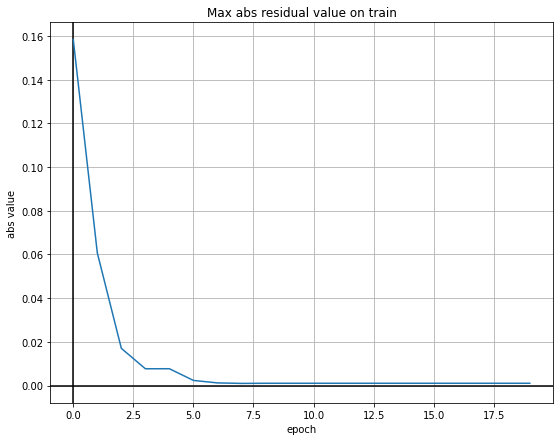

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.0007052421569824219
Valid max absolute error |Appr(x)-y(x)|: 0.000676080584526062
MAPE on train data: 0.07254605297930539 %
MAPE on validation data: 0.07304089376702905 %
Max abs value of residual on train at last epoch: 0.0010222196578979492 


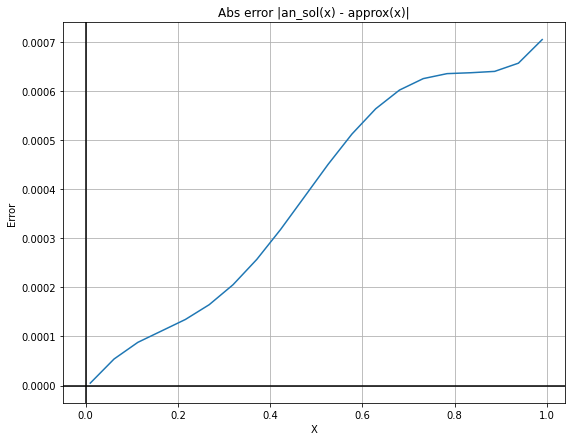

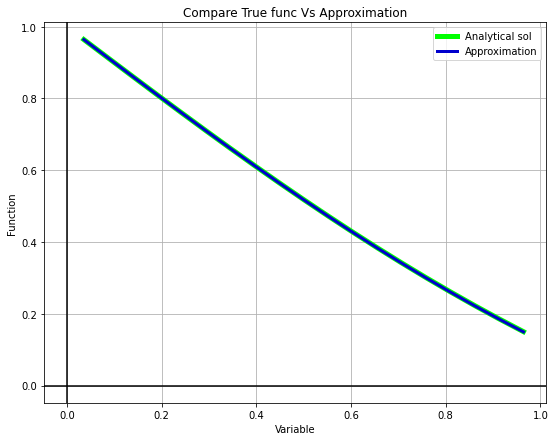

In [4]:
analytical_solution = lambda x: torch.exp(-x / 2) * (torch.cos(sqrt(3)/2*x) - torch.sin(sqrt(3)/2*x)/sqrt(3))
report = ReportMaker(nn_model,
                         loss_train,
                         loss_valid,
                         main_domain,
                         compare_to_functions=plot_two_1d_functions,
                         analytical_solutions=analytical_solution
                         )
report.print_loss_history()
report.compare_appr_with_analytical()

# № 2

$$ u'(x) + 2u(x)+5\int_{0}^xu(t)dt = \theta(x)$$
$$u(0)=0$$
$$ true\_sol = \frac{1}{2}exp(-x)sin(2x)\theta(x) $$
$$ \theta(x) = \begin{equation}
    \begin{cases}
      1, x \ge 0 \\
      0, x < 0
    \end{cases}\,.
\end{equation}$$

In [5]:
left_border = 0
right_border = 1
integration_func = lambda curr_v, int_domain, nn_model: nn_model(int_domain)
theta_func = lambda x: torch.tensor((x >= 0).float(), requires_grad=True)
main_eq_residual = (
    lambda x, nn_model: nth_derivative(nn_model(x), x, 1)
    + 2*nn_model(x)
    + 5*IntegralEquations.calculateVolterraEquation1D(
        integration_func,
        nn_model,
        x,
        left_border,
        right_border,
        n_points) - theta_func(x))
n_points = 20

main_domain = OneDimensionalSimpleDomain(left_border, right_border, n_points)


first_init_cond_res = lambda x, nn_model: nn_model(x)
first_init_cond = OnePointInitialCondition(left_border, first_init_cond_res)

boundary_conditions = [first_init_cond]

main_eq = MainEquationClass(main_domain, main_eq_residual, boundary_conditions)


n_epochs = 5
nn_ode_solver = TrainerForNNEquationSolver(main_eq, lr = 0.5)
loss_train, loss_valid, nn_model = nn_ode_solver.fit()

<ipython-input-5-aed5f2650757>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_func = lambda x: torch.tensor((x >= 0).float(), requires_grad=True)


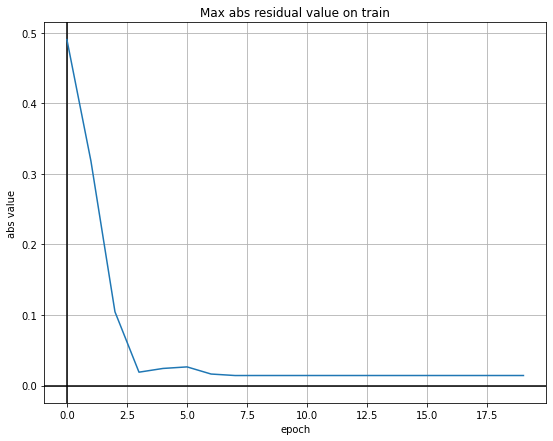

<ipython-input-5-aed5f2650757>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_func = lambda x: torch.tensor((x >= 0).float(), requires_grad=True)


Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.016048341989517212
Valid max absolute error |Appr(x)-y(x)|: 0.016070768237113953
MAPE on train data: 5.188912525773048 %
MAPE on validation data: 5.158288404345512 %
Max abs value of residual on train at last epoch: 0.014163970947265625 


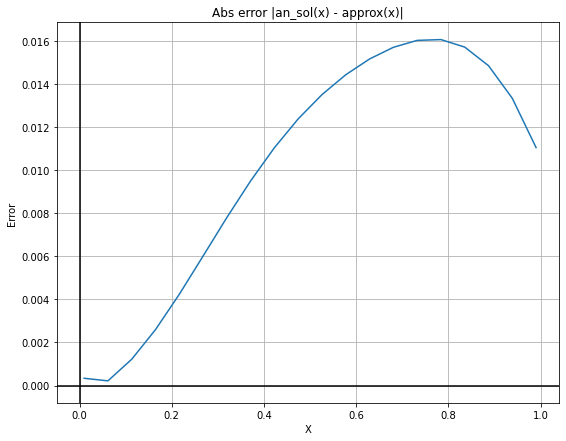

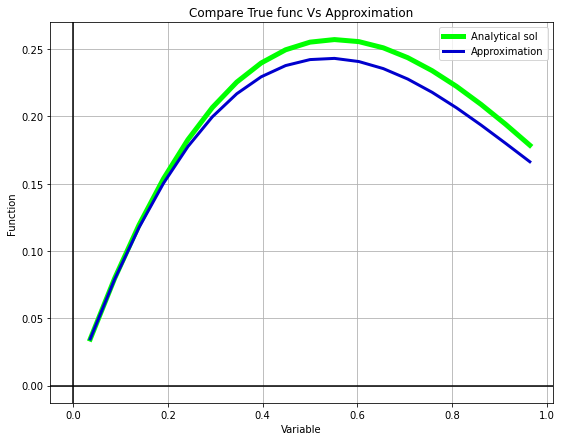

In [6]:
analytical_solution = lambda x: 0.5*torch.exp(-x) * torch.sin(2*x)*theta_func(x)
report = ReportMaker(nn_model,
                         loss_train,
                         loss_valid,
                         main_domain,
                         compare_to_functions=plot_two_1d_functions,
                         analytical_solutions=analytical_solution
                         )
report.print_loss_history()
report.compare_appr_with_analytical()

# № 3

$$ y'(x) -y(x) + \int_{0}^x(x-t)y'(t)dt - \int_{0}^xy(t)dt = x$$
$$y(0)=-1$$
$$ true\_sol = -exp(x) $$

In [7]:
left_border = 0
right_border = 1
integration_func1 = lambda curr_v, int_domain, nn_model: (curr_v - int_domain)*nth_derivative(nn_model(int_domain), int_domain, 1)
integration_func2 = lambda curr_v, int_domain, nn_model: nn_model(int_domain)
main_eq_residual = (
    lambda x, nn_model: nth_derivative(nn_model(x), x, 1)
    - nn_model(x)
    + IntegralEquations.calculateVolterraEquation1D(
        integration_func1,
        nn_model,
        x,
        left_border,
        right_border,
        50)
    - IntegralEquations.calculateVolterraEquation1D(
        integration_func2,
        nn_model,
        x,
        left_border,
        right_border,
        50)
    -x)
n_points = 20

main_domain = OneDimensionalSimpleDomain(left_border, right_border, n_points)


first_init_cond_res = lambda x, nn_model: nn_model(x) - torch.tensor([-1.0], requires_grad=True)
first_init_cond = OnePointInitialCondition(left_border, first_init_cond_res)

boundary_conditions = [first_init_cond]

main_eq = MainEquationClass(main_domain, main_eq_residual, boundary_conditions)


n_epochs = 20
nn_ode_solver = TrainerForNNEquationSolver(main_eq)
loss_train, loss_valid, nn_model = nn_ode_solver.fit()

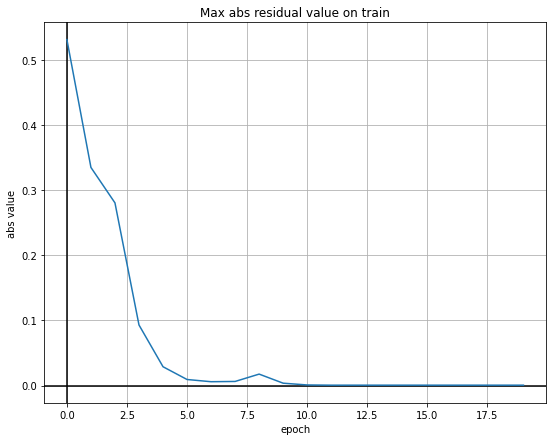

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.5066988468170166
Valid max absolute error |Appr(x)-y(x)|: 0.4727354049682617
MAPE on train data: 8.737019449472427 %
MAPE on validation data: 8.432424813508987 %
Max abs value of residual on train at last epoch: 0.0005053281784057617 


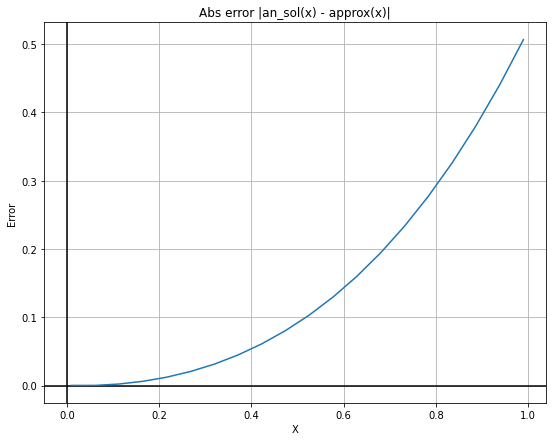

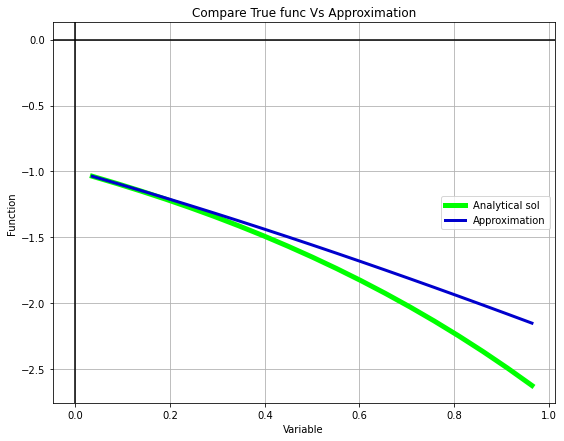

In [8]:
analytical_solution = lambda x: -torch.exp(x)
report = ReportMaker(nn_model,
                         loss_train,
                         loss_valid,
                         main_domain,
                         compare_to_functions=plot_two_1d_functions,
                         analytical_solutions=analytical_solution
                         )
report.print_loss_history()
report.compare_appr_with_analytical()

# № 4

$$ y'(x) + \int_{0}^xexp(-2(x-t))ydt = 0$$
$$y(0)=1$$
$$ true\_sol = (1+x)exp(-x) $$

In [9]:
left_border = 0
right_border = 1
integration_func = lambda curr_v, int_domain, nn_model: torch.exp(-2*(curr_v-int_domain))*nn_model(int_domain)
main_eq_residual = (
    lambda x, nn_model: nth_derivative(nn_model(x), x, 1)
    + IntegralEquations.calculateVolterraEquation1D(
        integration_func,
        nn_model,
        x,
        left_border,
        right_border,
        50))
n_points = 20

main_domain = OneDimensionalSimpleDomain(left_border, right_border, n_points)


first_init_cond_res = lambda x, nn_model: nn_model(x) - torch.tensor([1.0], requires_grad=True)
first_init_cond = OnePointInitialCondition(left_border, first_init_cond_res)

boundary_conditions = [first_init_cond]

main_eq = MainEquationClass(main_domain, main_eq_residual, boundary_conditions, bound_coefficient=20)


n_epochs = 40
nn_ode_solver = TrainerForNNEquationSolver(main_eq, lr=1e-2)
loss_train, loss_valid, nn_model = nn_ode_solver.fit()

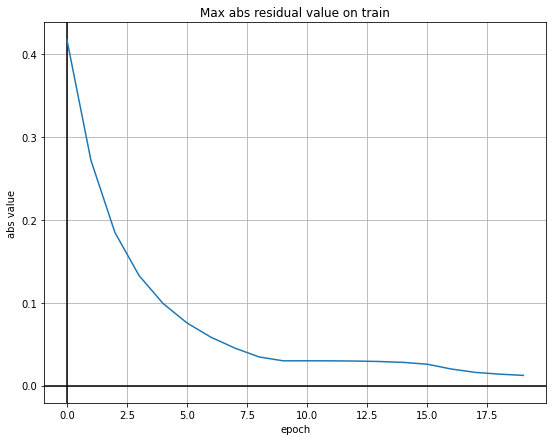

Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.18024402856826782
Valid max absolute error |Appr(x)-y(x)|: 0.1729990839958191
MAPE on train data: 7.73652195930481 %
MAPE on validation data: 7.5842104852199554 %
Max abs value of residual on train at last epoch: 0.012216523289680481 


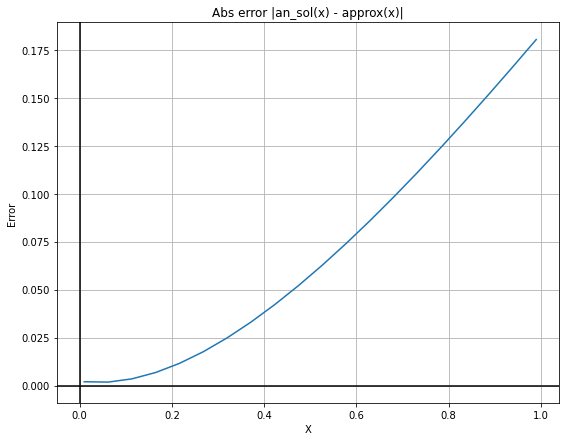

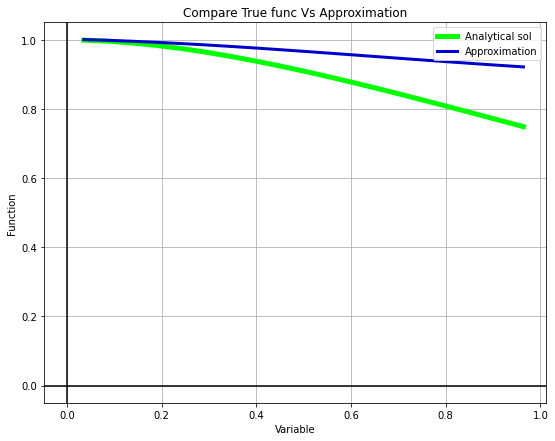

In [10]:
analytical_solution = lambda x: (1+x)*torch.exp(-x)
report = ReportMaker(nn_model,
                         loss_train,
                         loss_valid,
                         main_domain,
                         compare_to_functions=plot_two_1d_functions,
                         analytical_solutions=analytical_solution
                         )
report.print_loss_history()
report.compare_appr_with_analytical()